<a href="https://colab.research.google.com/github/ejrtks1020/TensorFlow-PyTorch-Vision/blob/main/tf_keras_neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


In [2]:
# tensor를 이미지로 변환
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype = np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
    
  return PIL.Image.fromarray(tensor)

In [32]:
# 경로에서 이미지를 불러오는 함수
def load_img(image_path):
  max_dim = 512
  img = tf.io.read_file(image_path)
  # 이미지를 텐서로 변환
  img = tf.image.decode_image(img, channels = 3) 
  # 이미지 데이터 타입을 float으로 변경하고 0에서 1사이 값으로 scaling
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  # w, h의 최대 크기를 max_dim에 맞춘다.
  long_dim = max(shape) 
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]

  return img

In [5]:
# 이미지를 화면에 그리는 함수
def imshow(image, title = None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis = 0)
  
  plt.imshow(image)
  if title:
    plt.title(title)

In [46]:
# 값을 0~1사이로 자르는 함수
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

# gram matrix 정의
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

  return result/(num_locations)

In [7]:
# 학습을 위한 파라미터값
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30 # 스타일 전이시 발생하는 노이즈를 제거하는 함수
epochs = 10
steps_per_epoch = 100

In [8]:
# content 이미지와 style 이미지 다운로드
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


In [11]:
# content 이미지와 style 이미지를 불러온뒤 출력
content_image = load_img(content_path)
style_image = load_img(style_path)

In [14]:
content_image.shape, style_image.shape

(TensorShape([1, 422, 512, 3]), TensorShape([1, 336, 512, 3]))

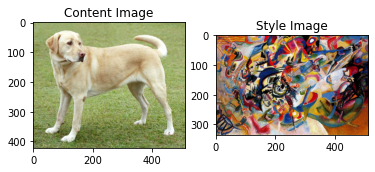

In [15]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [16]:
# imagenet 데이터셋으로 사전 학습된 VGGNet을 불러오고 각 레이어 이름을 출력
vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [17]:
# content 이미지에서 feature map을 추출할 레이어를 지정
content_layers = ['block5_conv2']

# style 이미지에서 feature map을 추출할 레이어들을 지정
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [20]:
# VGGNet 중간 레이어에서 추출한 feature map들을 반환하는 함수
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')

  # 스타일 전이에서는 CNN 부분은 학습하지 않기때문에 잠군다
  vgg.trainable = False

  # 중간 feature map 추출
  outputs = [vgg.get_layer(name).output for name in layer_names]
  
  model = tf.keras.Model([vgg.input], outputs)

  return model

In [33]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

In [37]:
# 5개의 스타일 이미지 feature map
len(style_outputs)

5

In [38]:
# 각 style 레이어의 feature map 정보를 출력
for name, output in zip(style_layers, style_outputs):
  print(name)
  print(" shape: ", output.numpy().shape)
  print(" min: ", output.numpy().min())
  print(" max: ", output.numpy().max())
  print(" mean: ", output.numpy().mean())
  print()

block1_conv1
 shape:  (1, 336, 512, 64)
 min:  0.0
 max:  835.5256
 mean:  33.97525

block2_conv1
 shape:  (1, 168, 256, 128)
 min:  0.0
 max:  4625.8857
 mean:  199.82687

block3_conv1
 shape:  (1, 84, 128, 256)
 min:  0.0
 max:  8789.239
 mean:  230.78099

block4_conv1
 shape:  (1, 42, 64, 512)
 min:  0.0
 max:  21566.135
 mean:  791.24005

block5_conv1
 shape:  (1, 21, 32, 512)
 min:  0.0
 max:  3189.2542
 mean:  59.179478



In [39]:
# tf.keras.Model을 이용해서 Neural Style Transfer 모델 정의
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg_trainable = False
  
  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    style_outputs = [gram_matrix(style_output)
                      for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value in zip(self.content_layers, content_outputs)}
    
    style_dict = {style_name: value 
                  for style_name, value in zip(self.style_layers, style_outputs)}
    
    return {'content': content_dict, 'style': style_dict}

In [40]:
# Neural Style Transfer 모델 선언
extractor = StyleContentModel(style_layers, content_layers)

# 컨텐트 이미지와 스타일 이미지로부터 feature map들을 추출
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [43]:
# 최적화를 위한 Adam 옵티마이저 선언
opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)

# Neural Style Transfer를 위한 loss 정의
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                          for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                                          for name in content_outputs.keys()])
  
  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss

  return loss

In [45]:
# total variation loss 정의
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)

  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [47]:
# 최적화를 위한 함수
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight * total_variation_loss(image)
  
  # image를 업데이트
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

....................................................................................................Train step : 100
....................................................................................................Train step : 200
....................................................................................................Train step : 300
....................................................................................................Train step : 400
....................................................................................................Train step : 500
....................................................................................................Train step : 600
....................................................................................................Train step : 700
....................................................................................................Train step : 800
................................................................

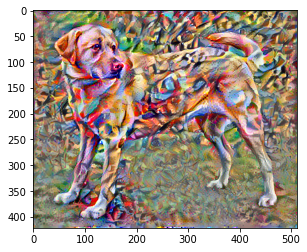

In [49]:
# 합성이미지로 최적화될 이미지를 tf.Variable로 선언, 빠른 학습을 위해서 content이미지로 초기화
synthetic_image = tf.Variable(content_image)

# epochs 만큼 최적화 진행
start = time.time()
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(synthetic_image)
    print(".", end = '')
  print("Train step : {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# 최적화 결과로 생성된 합성 이미지를 출력하고 저장
plt.imshow(tensor_to_image(synthetic_image))
plt.savefig('stylized-image.png')